## Wine Quality Dataset

Input variables (based on physicochemical tests):

1 - fixed acidity

2 - volatile acidity

3 - citric acid

4 - residual sugar

5 - chlorides

6 - free sulfur dioxide

7 - total sulfur dioxide

8 - density

9 - pH

10 - sulphates

11 - alcohol

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

I've added another output variable since there are two available dataset: a dataset set for red and white wine.

13 - wine type (classify if the wine would be a red wine (0) or a white wine (1))

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Importing Dataset

In [3]:
def import_dataset(white_dataset='winequality-white.csv', red_dataset='winequality-red.csv'):
    white_ds = pd.read_csv(white_dataset, delimiter=';')
    red_ds = pd.read_csv(red_dataset, delimiter=';')
    
    #add another feature: type of wine
    white_ds['wine_type'] = 1
    red_ds['wine_type'] = 0
    
    #merges the two dataset then renames feature columns that has whitespace
    merged_ds = white_ds.append(red_ds, ignore_index=True)
    for column in merged_ds.columns:
        new_column = column.replace(" ", "_")
        merged_ds = merged_ds.rename(columns={column: new_column})
    return merged_ds

In [4]:
merged_ds = import_dataset()

In [5]:
print("Merged Dataset Length:", len(merged_ds))

Merged Dataset Length: 6497


In [6]:
merged_ds.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

### EDA

In [7]:
merged_ds.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


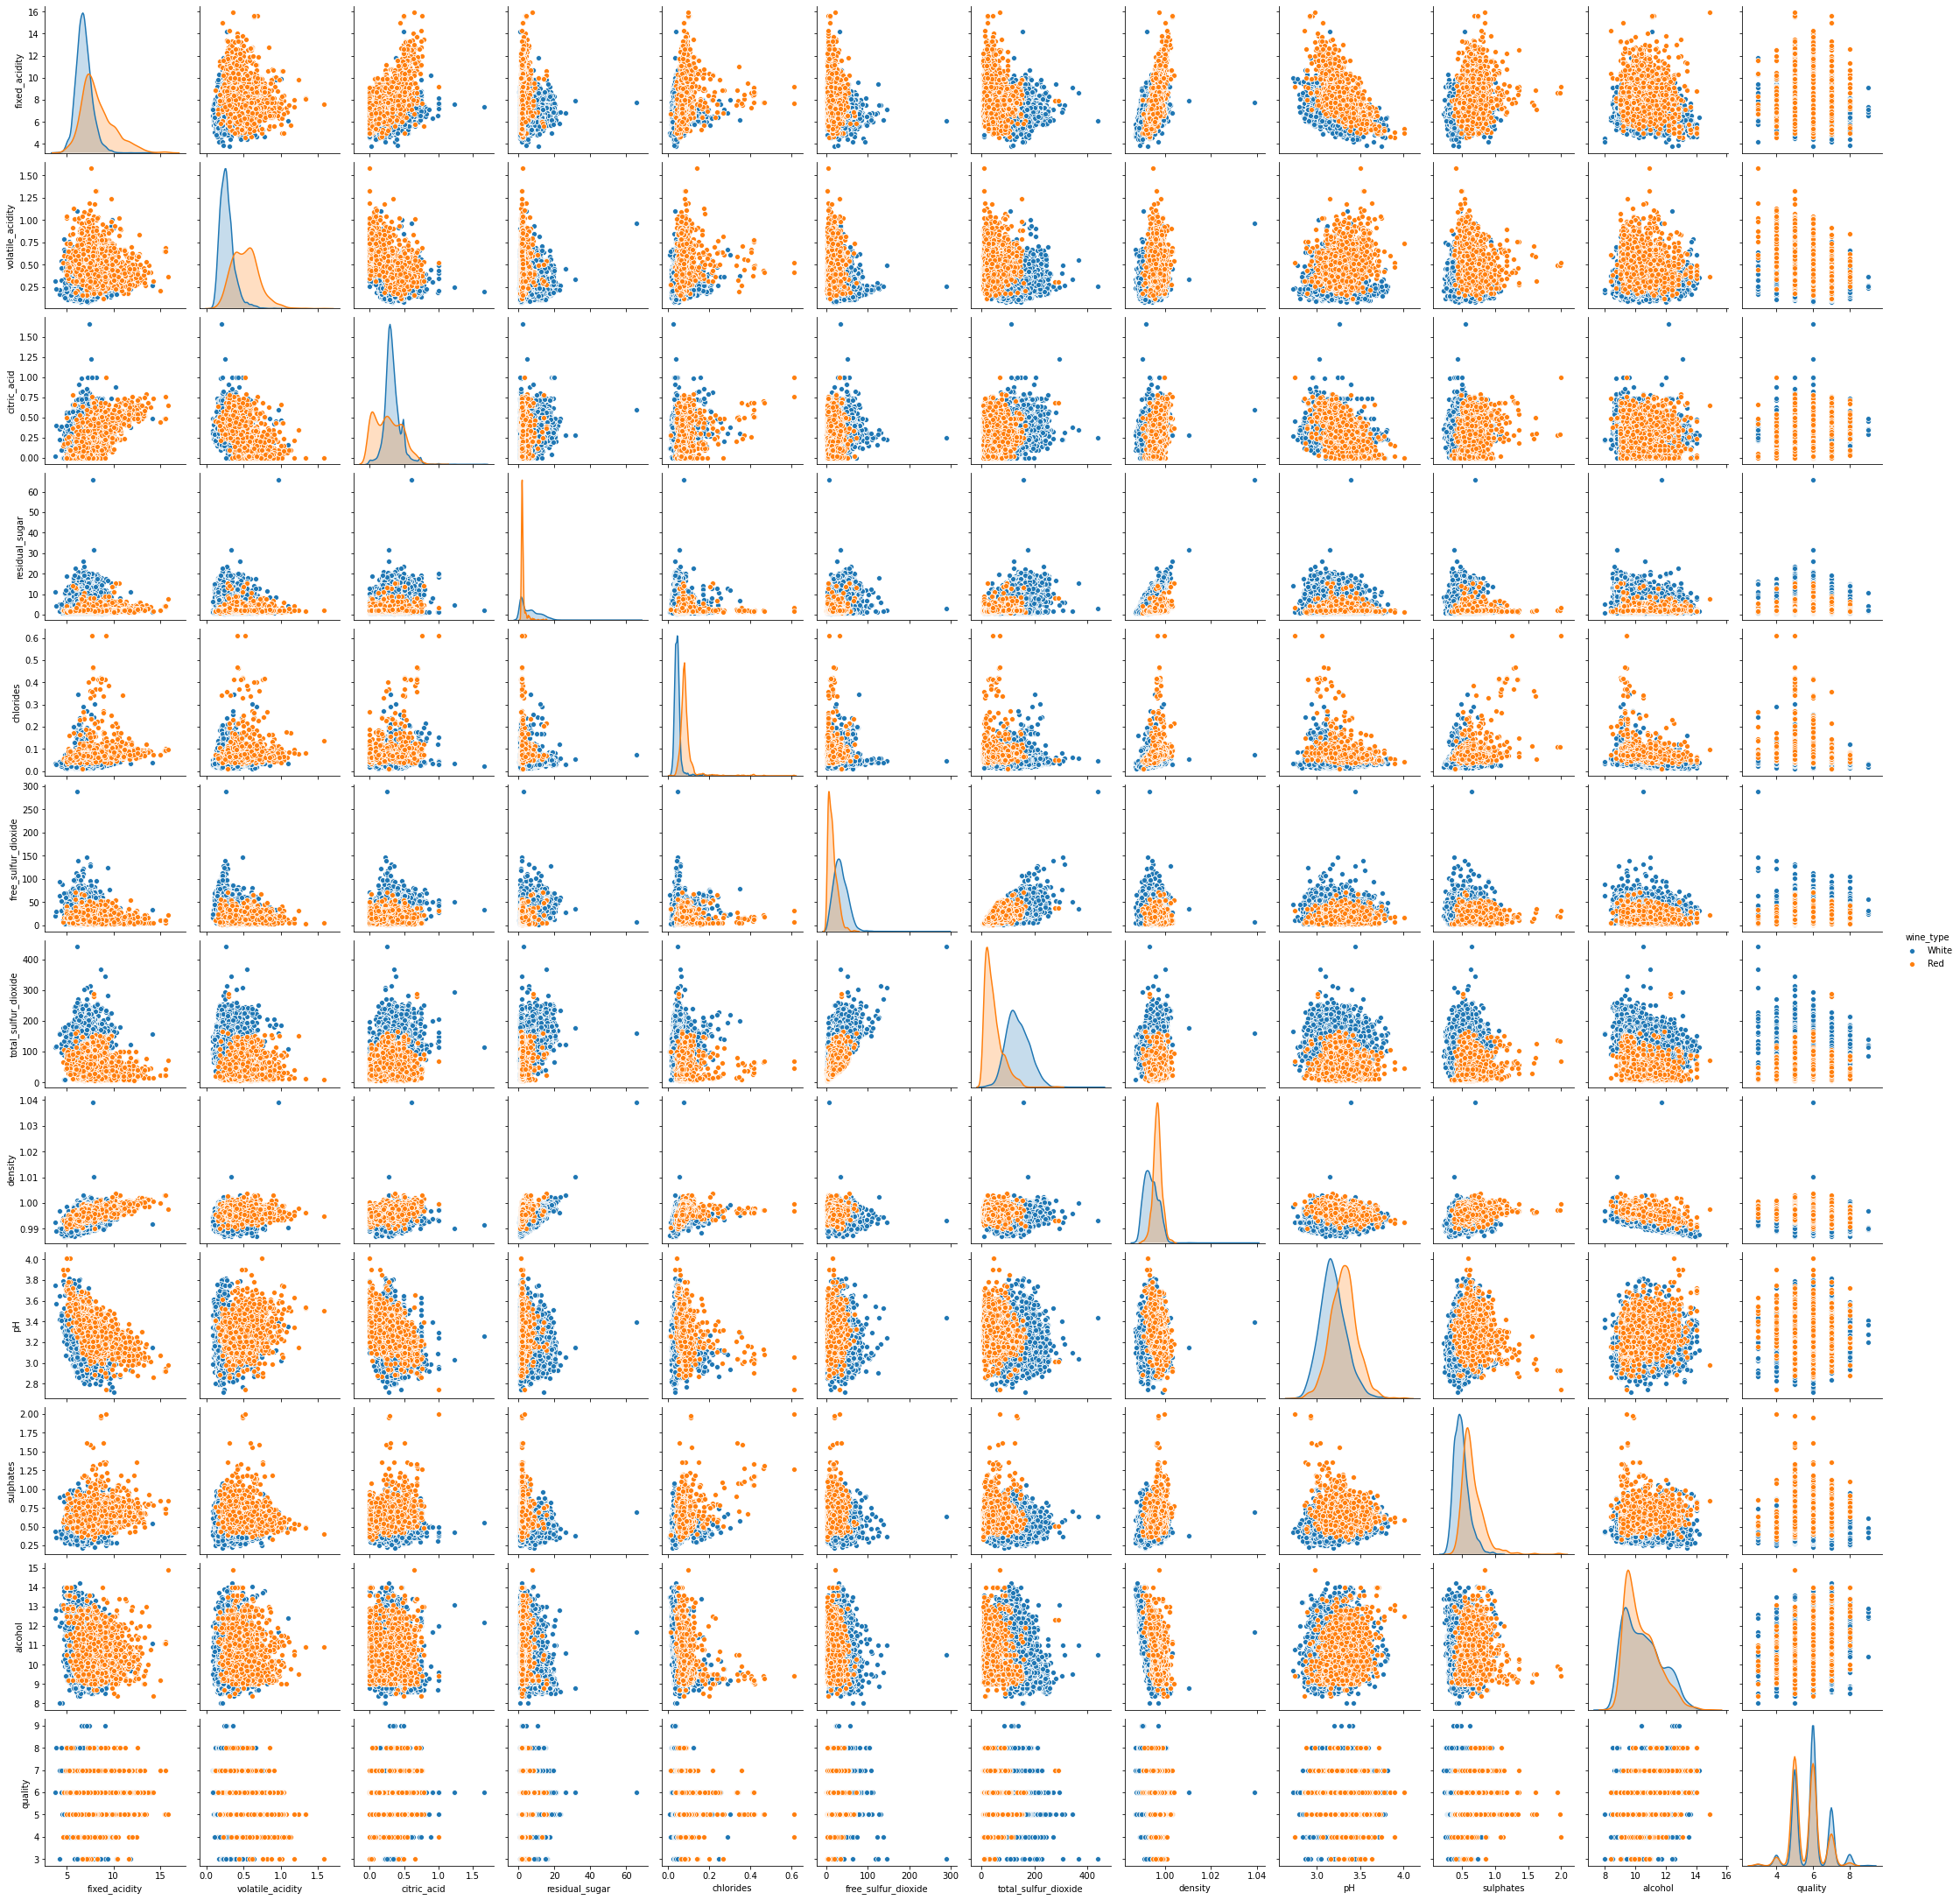

In [30]:
sns.pairplot(merged_ds, hue='wine_type')

### Preprocessing

In [8]:
merged_ds.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


Split dataset to train, validation and test sets

In [9]:
train, test = train_test_split(merged_ds, test_size=0.20, random_state=1)
train, val = train_test_split(train, test_size=0.20, random_state=1)
print("Full Dataset Size:", len(merged_ds))
print("Train Size: ", len(train))
print("Val Size: ", len(val))
print("Test y Size: ", len(test))

Full Dataset Size: 6497
Train Size:  4157
Val Size:  1040
Test y Size:  1300


Transforms the dataset from a panda dataframe into tensorflow dataset

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    quality = dataframe.pop('quality')
    is_white = dataframe.pop('wine_type')
    labels = (quality, is_white)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [11]:
BATCH_SIZE = 32
train_ds = df_to_dataset(train, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test, batch_size=BATCH_SIZE)

In [12]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['sulphates'])
    print('A batch of targets:', label_batch)

Every feature: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
A batch of ages: tf.Tensor(
[0.65 0.59 0.42 0.64 0.4  0.43 0.57 0.58 0.59 0.41 0.53 0.6  0.7  0.39
 0.62 0.5  0.49 0.36 0.64 0.72 0.52 0.78 0.58 0.55 0.38 0.98 0.53 0.49
 0.41 0.31 0.45 0.59], shape=(32,), dtype=float64)
A batch of targets: (<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([5, 6, 6, 8, 6, 5, 5, 6, 5, 7, 6, 6, 6, 6, 5, 5, 5, 5, 6, 7, 5, 6,
       6, 5, 7, 6, 5, 7, 7, 6, 5, 5], dtype=int64)>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)>)


In [13]:
merged_ds.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [14]:
train_ds

<BatchDataset shapes: ({fixed_acidity: (None,), volatile_acidity: (None,), citric_acid: (None,), residual_sugar: (None,), chlorides: (None,), free_sulfur_dioxide: (None,), total_sulfur_dioxide: (None,), density: (None,), pH: (None,), sulphates: (None,), alcohol: (None,)}, ((None,), (None,))), types: ({fixed_acidity: tf.float64, volatile_acidity: tf.float64, citric_acid: tf.float64, residual_sugar: tf.float64, chlorides: tf.float64, free_sulfur_dioxide: tf.float64, total_sulfur_dioxide: tf.float64, density: tf.float64, pH: tf.float64, sulphates: tf.float64, alcohol: tf.float64}, (tf.int64, tf.int64))>

In [15]:
def get_normalization_layer(name, dataset):
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [16]:
all_inputs = []
encoded_features = []

In [17]:
for header in ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

Model building using Functional API

In [18]:
def base_model(inputs):
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

In [19]:
def final_model(inputs):
    x = base_model(inputs)
    wine_quality = tf.keras.layers.Dense(1, name='wine_quality')(x)
    wine_type = tf.keras.layers.Dense(1, activation='sigmoid', name='wine_type')(x)
    model = tf.keras.models.Model(inputs=all_inputs, outputs=[wine_quality, wine_type])
    return model

In [20]:
all_features = tf.keras.layers.concatenate(encoded_features)
model = final_model(all_features)

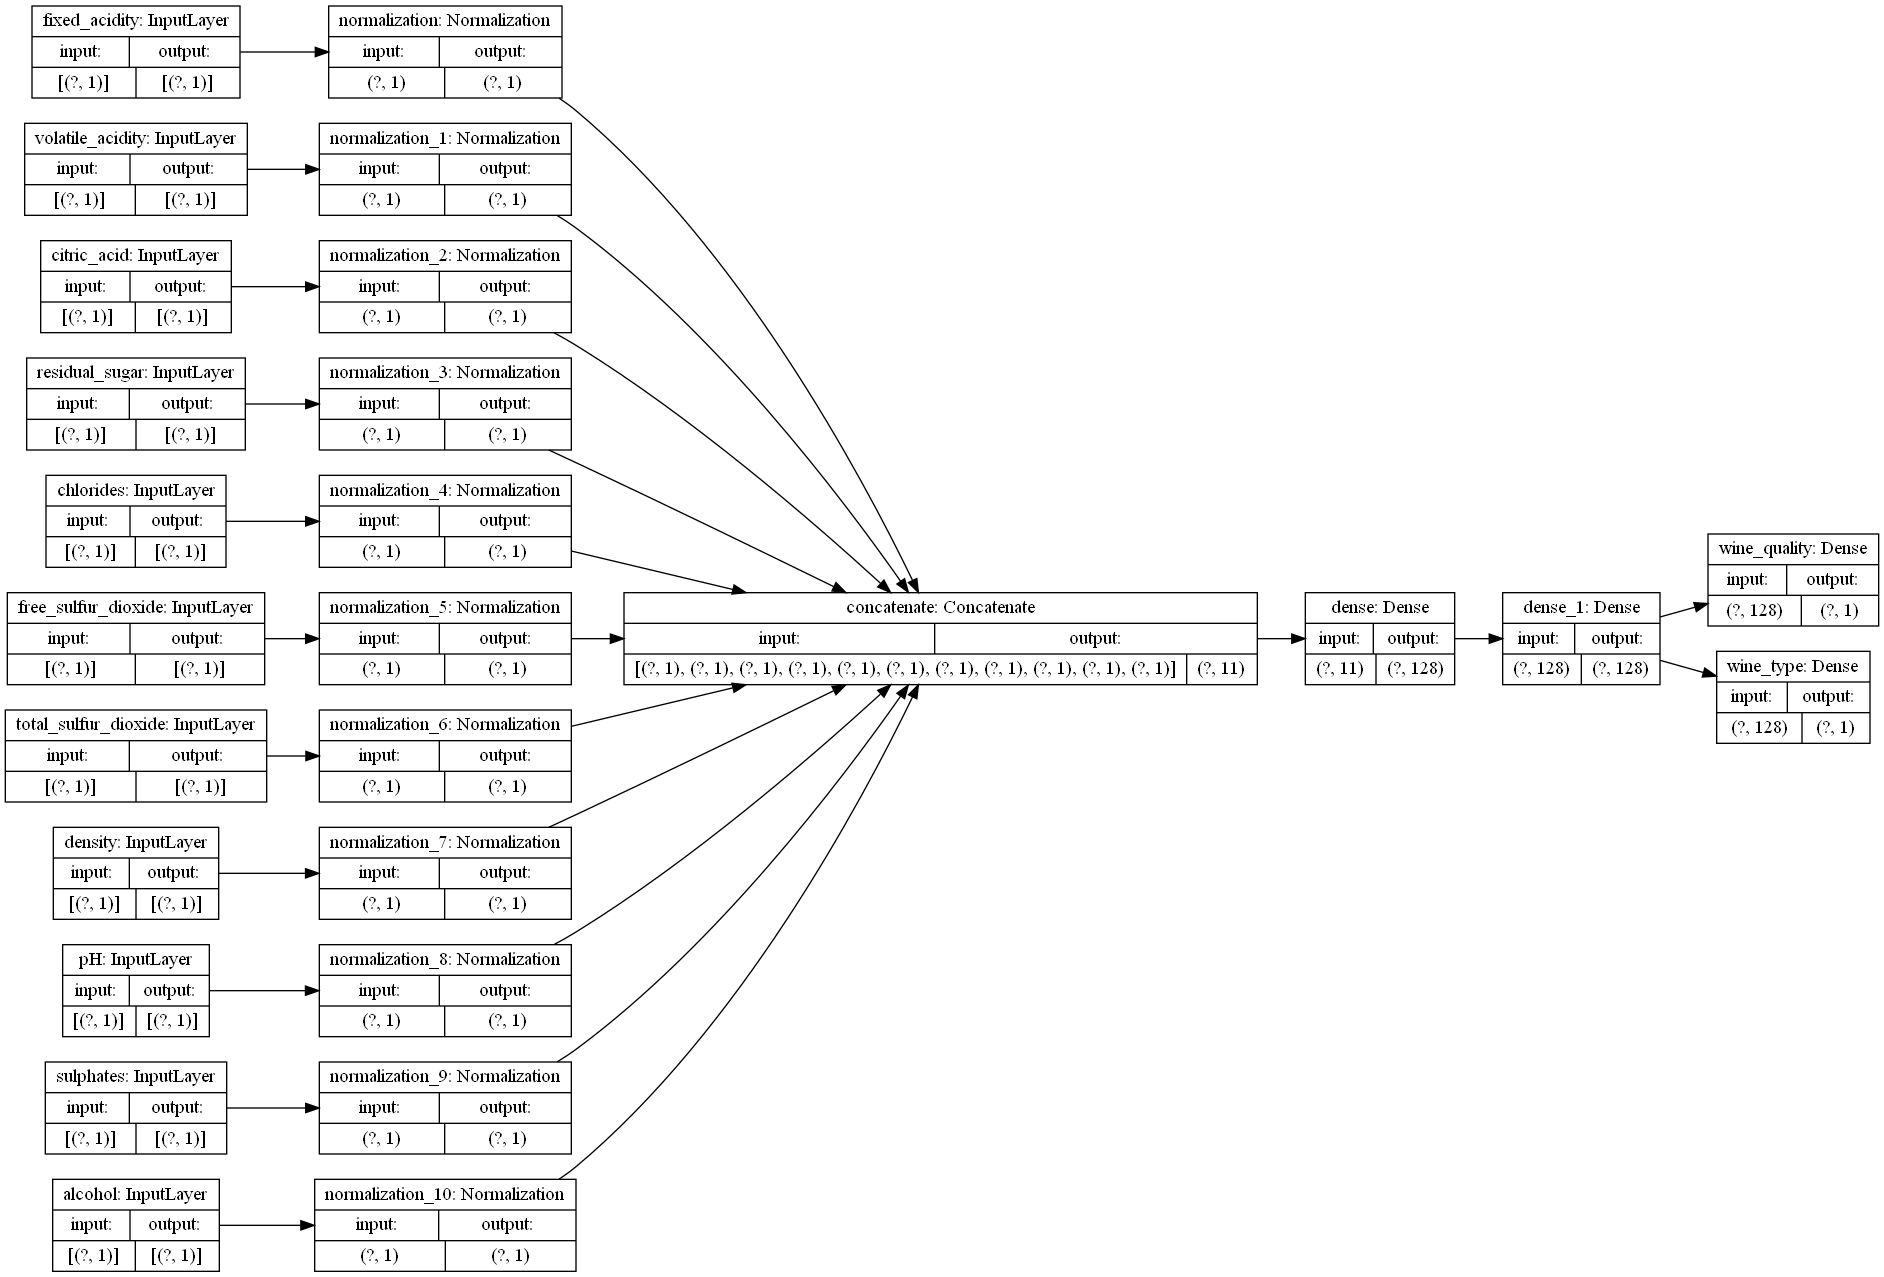

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR", to_file='model.png')

In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fixed_acidity (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
volatile_acidity (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
citric_acid (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
residual_sugar (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

Compiling Model

In [23]:
model.compile(optimizer='adam', loss={'wine_type':'binary_crossentropy', 'wine_quality': 'mse'},
              metrics={'wine_type': tf.keras.metrics.Recall() , 'wine_quality': tf.keras.metrics.RootMeanSquaredError()})

Training Model

In [24]:
history = model.fit(train_ds, epochs=500, verbose=1
                    , validation_data=val_ds)

Epoch 1/500
130/130 [==============================] - 1s 8ms/step - loss: 4.9742 - wine_quality_loss: 4.6710 - wine_type_loss: 0.3032 - wine_quality_root_mean_squared_error: 2.1612 - wine_type_recall: 0.9946 - val_loss: 1.7543 - val_wine_quality_loss: 1.6506 - val_wine_type_loss: 0.1037 - val_wine_quality_root_mean_squared_error: 1.2847 - val_wine_type_recall: 0.9935
Epoch 2/500
130/130 [==============================] - 1s 5ms/step - loss: 1.5089 - wine_quality_loss: 1.4404 - wine_type_loss: 0.0685 - wine_quality_root_mean_squared_error: 1.2002 - wine_type_recall: 0.9946 - val_loss: 1.1676 - val_wine_quality_loss: 1.1189 - val_wine_type_loss: 0.0487 - val_wine_quality_root_mean_squared_error: 1.0578 - val_wine_type_recall: 0.9948
Epoch 3/500
130/130 [==============================] - 1s 5ms/step - loss: 1.0180 - wine_quality_loss: 0.9737 - wine_type_loss: 0.0443 - wine_quality_root_mean_squared_error: 0.9868 - wine_type_recall: 0.9955 - val_loss: 0.8669 - val_wine_quality_loss: 0.830

130/130 [==============================] - 1s 5ms/step - loss: 0.4281 - wine_quality_loss: 0.4119 - wine_type_loss: 0.0163 - wine_quality_root_mean_squared_error: 0.6418 - wine_type_recall: 0.9994 - val_loss: 0.5326 - val_wine_quality_loss: 0.5191 - val_wine_type_loss: 0.0136 - val_wine_quality_root_mean_squared_error: 0.7205 - val_wine_type_recall: 0.9987
Epoch 24/500
130/130 [==============================] - 1s 5ms/step - loss: 0.4199 - wine_quality_loss: 0.4042 - wine_type_loss: 0.0157 - wine_quality_root_mean_squared_error: 0.6358 - wine_type_recall: 0.9990 - val_loss: 0.5314 - val_wine_quality_loss: 0.5186 - val_wine_type_loss: 0.0128 - val_wine_quality_root_mean_squared_error: 0.7202 - val_wine_type_recall: 0.9987
Epoch 25/500
130/130 [==============================] - 1s 5ms/step - loss: 0.4279 - wine_quality_loss: 0.4127 - wine_type_loss: 0.0152 - wine_quality_root_mean_squared_error: 0.6424 - wine_type_recall: 0.9994 - val_loss: 0.5043 - val_wine_quality_loss: 0.4915 - val_wi

130/130 [==============================] - 1s 5ms/step - loss: 0.3641 - wine_quality_loss: 0.3545 - wine_type_loss: 0.0096 - wine_quality_root_mean_squared_error: 0.5954 - wine_type_recall: 0.9997 - val_loss: 0.5277 - val_wine_quality_loss: 0.5184 - val_wine_type_loss: 0.0093 - val_wine_quality_root_mean_squared_error: 0.7200 - val_wine_type_recall: 0.9987
Epoch 46/500
130/130 [==============================] - 1s 5ms/step - loss: 0.3547 - wine_quality_loss: 0.3449 - wine_type_loss: 0.0097 - wine_quality_root_mean_squared_error: 0.5873 - wine_type_recall: 0.9994 - val_loss: 0.5033 - val_wine_quality_loss: 0.4938 - val_wine_type_loss: 0.0095 - val_wine_quality_root_mean_squared_error: 0.7027 - val_wine_type_recall: 0.9987
Epoch 47/500
130/130 [==============================] - 1s 5ms/step - loss: 0.3538 - wine_quality_loss: 0.3444 - wine_type_loss: 0.0094 - wine_quality_root_mean_squared_error: 0.5869 - wine_type_recall: 0.9997 - val_loss: 0.5542 - val_wine_quality_loss: 0.5453 - val_wi

130/130 [==============================] - 1s 5ms/step - loss: 0.3128 - wine_quality_loss: 0.3065 - wine_type_loss: 0.0064 - wine_quality_root_mean_squared_error: 0.5536 - wine_type_recall: 1.0000 - val_loss: 0.5081 - val_wine_quality_loss: 0.4996 - val_wine_type_loss: 0.0085 - val_wine_quality_root_mean_squared_error: 0.7068 - val_wine_type_recall: 0.9987
Epoch 68/500
130/130 [==============================] - 1s 5ms/step - loss: 0.2995 - wine_quality_loss: 0.2937 - wine_type_loss: 0.0058 - wine_quality_root_mean_squared_error: 0.5420 - wine_type_recall: 1.0000 - val_loss: 0.5227 - val_wine_quality_loss: 0.5146 - val_wine_type_loss: 0.0081 - val_wine_quality_root_mean_squared_error: 0.7173 - val_wine_type_recall: 0.9987
Epoch 69/500
130/130 [==============================] - 1s 5ms/step - loss: 0.3026 - wine_quality_loss: 0.2968 - wine_type_loss: 0.0058 - wine_quality_root_mean_squared_error: 0.5448 - wine_type_recall: 1.0000 - val_loss: 0.5157 - val_wine_quality_loss: 0.5073 - val_wi

130/130 [==============================] - 1s 5ms/step - loss: 0.2728 - wine_quality_loss: 0.2695 - wine_type_loss: 0.0033 - wine_quality_root_mean_squared_error: 0.5191 - wine_type_recall: 1.0000 - val_loss: 0.5241 - val_wine_quality_loss: 0.5143 - val_wine_type_loss: 0.0098 - val_wine_quality_root_mean_squared_error: 0.7171 - val_wine_type_recall: 0.9987
Epoch 90/500
130/130 [==============================] - 1s 5ms/step - loss: 0.2642 - wine_quality_loss: 0.2612 - wine_type_loss: 0.0030 - wine_quality_root_mean_squared_error: 0.5111 - wine_type_recall: 1.0000 - val_loss: 0.5180 - val_wine_quality_loss: 0.5087 - val_wine_type_loss: 0.0094 - val_wine_quality_root_mean_squared_error: 0.7132 - val_wine_type_recall: 0.9987
Epoch 91/500
130/130 [==============================] - 1s 5ms/step - loss: 0.2648 - wine_quality_loss: 0.2618 - wine_type_loss: 0.0030 - wine_quality_root_mean_squared_error: 0.5117 - wine_type_recall: 1.0000 - val_loss: 0.5464 - val_wine_quality_loss: 0.5376 - val_wi

130/130 [==============================] - 1s 5ms/step - loss: 0.2371 - wine_quality_loss: 0.2349 - wine_type_loss: 0.0022 - wine_quality_root_mean_squared_error: 0.4846 - wine_type_recall: 0.9997 - val_loss: 0.5427 - val_wine_quality_loss: 0.5341 - val_wine_type_loss: 0.0086 - val_wine_quality_root_mean_squared_error: 0.7308 - val_wine_type_recall: 0.9987
Epoch 112/500
130/130 [==============================] - 1s 5ms/step - loss: 0.2419 - wine_quality_loss: 0.2403 - wine_type_loss: 0.0017 - wine_quality_root_mean_squared_error: 0.4902 - wine_type_recall: 0.9997 - val_loss: 0.5532 - val_wine_quality_loss: 0.5441 - val_wine_type_loss: 0.0091 - val_wine_quality_root_mean_squared_error: 0.7376 - val_wine_type_recall: 0.9987
Epoch 113/500
130/130 [==============================] - 1s 5ms/step - loss: 0.2279 - wine_quality_loss: 0.2261 - wine_type_loss: 0.0018 - wine_quality_root_mean_squared_error: 0.4755 - wine_type_recall: 0.9994 - val_loss: 0.5403 - val_wine_quality_loss: 0.5311 - val_

130/130 [==============================] - 1s 5ms/step - loss: 0.2182 - wine_quality_loss: 0.2166 - wine_type_loss: 0.0016 - wine_quality_root_mean_squared_error: 0.4654 - wine_type_recall: 0.9994 - val_loss: 0.5344 - val_wine_quality_loss: 0.5247 - val_wine_type_loss: 0.0097 - val_wine_quality_root_mean_squared_error: 0.7244 - val_wine_type_recall: 0.9987
Epoch 134/500
130/130 [==============================] - 1s 5ms/step - loss: 0.2061 - wine_quality_loss: 0.2048 - wine_type_loss: 0.0013 - wine_quality_root_mean_squared_error: 0.4525 - wine_type_recall: 0.9994 - val_loss: 0.5434 - val_wine_quality_loss: 0.5337 - val_wine_type_loss: 0.0097 - val_wine_quality_root_mean_squared_error: 0.7305 - val_wine_type_recall: 0.9987
Epoch 135/500
130/130 [==============================] - 1s 5ms/step - loss: 0.2176 - wine_quality_loss: 0.2163 - wine_type_loss: 0.0013 - wine_quality_root_mean_squared_error: 0.4650 - wine_type_recall: 0.9994 - val_loss: 0.5705 - val_wine_quality_loss: 0.5610 - val_

130/130 [==============================] - 1s 5ms/step - loss: 0.1831 - wine_quality_loss: 0.1817 - wine_type_loss: 0.0015 - wine_quality_root_mean_squared_error: 0.4262 - wine_type_recall: 0.9997 - val_loss: 0.5647 - val_wine_quality_loss: 0.5540 - val_wine_type_loss: 0.0107 - val_wine_quality_root_mean_squared_error: 0.7443 - val_wine_type_recall: 0.9987
Epoch 156/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1834 - wine_quality_loss: 0.1818 - wine_type_loss: 0.0015 - wine_quality_root_mean_squared_error: 0.4264 - wine_type_recall: 0.9994 - val_loss: 0.5608 - val_wine_quality_loss: 0.5502 - val_wine_type_loss: 0.0106 - val_wine_quality_root_mean_squared_error: 0.7418 - val_wine_type_recall: 0.9987
Epoch 157/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1938 - wine_quality_loss: 0.1923 - wine_type_loss: 0.0015 - wine_quality_root_mean_squared_error: 0.4385 - wine_type_recall: 0.9994 - val_loss: 0.5850 - val_wine_quality_loss: 0.5752 - val_

130/130 [==============================] - 1s 5ms/step - loss: 0.1598 - wine_quality_loss: 0.1587 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.3984 - wine_type_recall: 0.9994 - val_loss: 0.6182 - val_wine_quality_loss: 0.6080 - val_wine_type_loss: 0.0103 - val_wine_quality_root_mean_squared_error: 0.7797 - val_wine_type_recall: 0.9987
Epoch 178/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1724 - wine_quality_loss: 0.1712 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.4138 - wine_type_recall: 0.9997 - val_loss: 0.6176 - val_wine_quality_loss: 0.6074 - val_wine_type_loss: 0.0102 - val_wine_quality_root_mean_squared_error: 0.7794 - val_wine_type_recall: 0.9987
Epoch 179/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1594 - wine_quality_loss: 0.1582 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3977 - wine_type_recall: 0.9994 - val_loss: 0.6045 - val_wine_quality_loss: 0.5944 - val_

130/130 [==============================] - 1s 5ms/step - loss: 0.1457 - wine_quality_loss: 0.1445 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3801 - wine_type_recall: 0.9994 - val_loss: 0.6110 - val_wine_quality_loss: 0.5996 - val_wine_type_loss: 0.0114 - val_wine_quality_root_mean_squared_error: 0.7743 - val_wine_type_recall: 0.9987
Epoch 200/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1636 - wine_quality_loss: 0.1621 - wine_type_loss: 0.0014 - wine_quality_root_mean_squared_error: 0.4026 - wine_type_recall: 0.9994 - val_loss: 0.6136 - val_wine_quality_loss: 0.6030 - val_wine_type_loss: 0.0106 - val_wine_quality_root_mean_squared_error: 0.7765 - val_wine_type_recall: 0.9987
Epoch 201/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1629 - wine_quality_loss: 0.1616 - wine_type_loss: 0.0013 - wine_quality_root_mean_squared_error: 0.4020 - wine_type_recall: 0.9994 - val_loss: 0.6061 - val_wine_quality_loss: 0.5948 - val_

130/130 [==============================] - 1s 5ms/step - loss: 0.1396 - wine_quality_loss: 0.1386 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.3722 - wine_type_recall: 0.9994 - val_loss: 0.6331 - val_wine_quality_loss: 0.6212 - val_wine_type_loss: 0.0120 - val_wine_quality_root_mean_squared_error: 0.7881 - val_wine_type_recall: 0.9987
Epoch 222/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1303 - wine_quality_loss: 0.1291 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3593 - wine_type_recall: 0.9994 - val_loss: 0.6257 - val_wine_quality_loss: 0.6144 - val_wine_type_loss: 0.0113 - val_wine_quality_root_mean_squared_error: 0.7838 - val_wine_type_recall: 0.9987
Epoch 223/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1348 - wine_quality_loss: 0.1336 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3655 - wine_type_recall: 0.9994 - val_loss: 0.6421 - val_wine_quality_loss: 0.6291 - val_

130/130 [==============================] - 1s 5ms/step - loss: 0.1141 - wine_quality_loss: 0.1131 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.3362 - wine_type_recall: 0.9994 - val_loss: 0.6477 - val_wine_quality_loss: 0.6351 - val_wine_type_loss: 0.0126 - val_wine_quality_root_mean_squared_error: 0.7969 - val_wine_type_recall: 0.9987
Epoch 244/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1283 - wine_quality_loss: 0.1271 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3565 - wine_type_recall: 0.9994 - val_loss: 0.6452 - val_wine_quality_loss: 0.6330 - val_wine_type_loss: 0.0122 - val_wine_quality_root_mean_squared_error: 0.7956 - val_wine_type_recall: 0.9987
Epoch 245/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1292 - wine_quality_loss: 0.1279 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3577 - wine_type_recall: 0.9997 - val_loss: 0.6593 - val_wine_quality_loss: 0.6475 - val_

Epoch 265/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1119 - wine_quality_loss: 0.1108 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.3328 - wine_type_recall: 0.9994 - val_loss: 0.6329 - val_wine_quality_loss: 0.6188 - val_wine_type_loss: 0.0141 - val_wine_quality_root_mean_squared_error: 0.7866 - val_wine_type_recall: 0.9987
Epoch 266/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1098 - wine_quality_loss: 0.1086 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3296 - wine_type_recall: 0.9997 - val_loss: 0.6482 - val_wine_quality_loss: 0.6357 - val_wine_type_loss: 0.0125 - val_wine_quality_root_mean_squared_error: 0.7973 - val_wine_type_recall: 0.9987
Epoch 267/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1144 - wine_quality_loss: 0.1133 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.3365 - wine_type_recall: 0.9994 - val_loss: 0.6532 - val_wine_quality_loss:

Epoch 287/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0974 - wine_quality_loss: 0.0960 - wine_type_loss: 0.0014 - wine_quality_root_mean_squared_error: 0.3099 - wine_type_recall: 0.9997 - val_loss: 0.6984 - val_wine_quality_loss: 0.6830 - val_wine_type_loss: 0.0153 - val_wine_quality_root_mean_squared_error: 0.8265 - val_wine_type_recall: 0.9987
Epoch 288/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0922 - wine_quality_loss: 0.0908 - wine_type_loss: 0.0014 - wine_quality_root_mean_squared_error: 0.3013 - wine_type_recall: 0.9994 - val_loss: 0.6828 - val_wine_quality_loss: 0.6677 - val_wine_type_loss: 0.0151 - val_wine_quality_root_mean_squared_error: 0.8171 - val_wine_type_recall: 0.9987
Epoch 289/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0941 - wine_quality_loss: 0.0929 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3048 - wine_type_recall: 0.9994 - val_loss: 0.6473 - val_wine_quality_loss:

130/130 [==============================] - 1s 5ms/step - loss: 0.0944 - wine_quality_loss: 0.0935 - wine_type_loss: 8.8685e-04 - wine_quality_root_mean_squared_error: 0.3058 - wine_type_recall: 0.9997 - val_loss: 0.6752 - val_wine_quality_loss: 0.6570 - val_wine_type_loss: 0.0182 - val_wine_quality_root_mean_squared_error: 0.8105 - val_wine_type_recall: 0.9987
Epoch 309/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0987 - wine_quality_loss: 0.0969 - wine_type_loss: 0.0018 - wine_quality_root_mean_squared_error: 0.3112 - wine_type_recall: 0.9997 - val_loss: 0.6677 - val_wine_quality_loss: 0.6509 - val_wine_type_loss: 0.0169 - val_wine_quality_root_mean_squared_error: 0.8068 - val_wine_type_recall: 0.9987
Epoch 310/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0929 - wine_quality_loss: 0.0914 - wine_type_loss: 0.0014 - wine_quality_root_mean_squared_error: 0.3024 - wine_type_recall: 0.9994 - val_loss: 0.6913 - val_wine_quality_loss: 0.6747 - 

Epoch 330/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0759 - wine_quality_loss: 0.0747 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.2734 - wine_type_recall: 0.9994 - val_loss: 0.6596 - val_wine_quality_loss: 0.6427 - val_wine_type_loss: 0.0170 - val_wine_quality_root_mean_squared_error: 0.8017 - val_wine_type_recall: 0.9987
Epoch 331/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0845 - wine_quality_loss: 0.0834 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.2888 - wine_type_recall: 0.9994 - val_loss: 0.6542 - val_wine_quality_loss: 0.6366 - val_wine_type_loss: 0.0176 - val_wine_quality_root_mean_squared_error: 0.7979 - val_wine_type_recall: 0.9987
Epoch 332/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0963 - wine_quality_loss: 0.0953 - wine_type_loss: 0.0010 - wine_quality_root_mean_squared_error: 0.3088 - wine_type_recall: 0.9994 - val_loss: 0.7201 - val_wine_quality_loss:

Epoch 352/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0851 - wine_quality_loss: 0.0841 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.2900 - wine_type_recall: 0.9997 - val_loss: 0.6733 - val_wine_quality_loss: 0.6576 - val_wine_type_loss: 0.0157 - val_wine_quality_root_mean_squared_error: 0.8109 - val_wine_type_recall: 0.9987
Epoch 353/500
130/130 [==============================] - 1s 5ms/step - loss: 0.1025 - wine_quality_loss: 0.1013 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.3183 - wine_type_recall: 0.9994 - val_loss: 0.6865 - val_wine_quality_loss: 0.6662 - val_wine_type_loss: 0.0202 - val_wine_quality_root_mean_squared_error: 0.8162 - val_wine_type_recall: 0.9987
Epoch 354/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0859 - wine_quality_loss: 0.0847 - wine_type_loss: 0.0013 - wine_quality_root_mean_squared_error: 0.2909 - wine_type_recall: 0.9994 - val_loss: 0.6642 - val_wine_quality_loss:

Epoch 374/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0673 - wine_quality_loss: 0.0654 - wine_type_loss: 0.0019 - wine_quality_root_mean_squared_error: 0.2557 - wine_type_recall: 0.9994 - val_loss: 0.6913 - val_wine_quality_loss: 0.6769 - val_wine_type_loss: 0.0144 - val_wine_quality_root_mean_squared_error: 0.8227 - val_wine_type_recall: 0.9987
Epoch 375/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0707 - wine_quality_loss: 0.0695 - wine_type_loss: 0.0013 - wine_quality_root_mean_squared_error: 0.2636 - wine_type_recall: 0.9997 - val_loss: 0.6923 - val_wine_quality_loss: 0.6784 - val_wine_type_loss: 0.0139 - val_wine_quality_root_mean_squared_error: 0.8236 - val_wine_type_recall: 0.9987
Epoch 376/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0707 - wine_quality_loss: 0.0693 - wine_type_loss: 0.0015 - wine_quality_root_mean_squared_error: 0.2632 - wine_type_recall: 0.9994 - val_loss: 0.6791 - val_wine_quality_loss:

Epoch 396/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0702 - wine_quality_loss: 0.0689 - wine_type_loss: 0.0013 - wine_quality_root_mean_squared_error: 0.2626 - wine_type_recall: 0.9994 - val_loss: 0.6648 - val_wine_quality_loss: 0.6498 - val_wine_type_loss: 0.0150 - val_wine_quality_root_mean_squared_error: 0.8061 - val_wine_type_recall: 0.9987
Epoch 397/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0667 - wine_quality_loss: 0.0656 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.2560 - wine_type_recall: 0.9994 - val_loss: 0.6834 - val_wine_quality_loss: 0.6680 - val_wine_type_loss: 0.0154 - val_wine_quality_root_mean_squared_error: 0.8173 - val_wine_type_recall: 0.9987
Epoch 398/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0591 - wine_quality_loss: 0.0581 - wine_type_loss: 0.0010 - wine_quality_root_mean_squared_error: 0.2411 - wine_type_recall: 0.9994 - val_loss: 0.6737 - val_wine_quality_loss:

Epoch 418/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0792 - wine_quality_loss: 0.0781 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.2795 - wine_type_recall: 0.9997 - val_loss: 0.6847 - val_wine_quality_loss: 0.6671 - val_wine_type_loss: 0.0175 - val_wine_quality_root_mean_squared_error: 0.8168 - val_wine_type_recall: 0.9987
Epoch 419/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0890 - wine_quality_loss: 0.0880 - wine_type_loss: 9.7235e-04 - wine_quality_root_mean_squared_error: 0.2967 - wine_type_recall: 0.9994 - val_loss: 0.7227 - val_wine_quality_loss: 0.7050 - val_wine_type_loss: 0.0177 - val_wine_quality_root_mean_squared_error: 0.8396 - val_wine_type_recall: 0.9987
Epoch 420/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0786 - wine_quality_loss: 0.0776 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.2785 - wine_type_recall: 0.9994 - val_loss: 0.6687 - val_wine_quality_l

Epoch 440/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0645 - wine_quality_loss: 0.0635 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.2520 - wine_type_recall: 0.9994 - val_loss: 0.6915 - val_wine_quality_loss: 0.6694 - val_wine_type_loss: 0.0221 - val_wine_quality_root_mean_squared_error: 0.8182 - val_wine_type_recall: 0.9987
Epoch 441/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0598 - wine_quality_loss: 0.0587 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.2422 - wine_type_recall: 0.9997 - val_loss: 0.7056 - val_wine_quality_loss: 0.6896 - val_wine_type_loss: 0.0160 - val_wine_quality_root_mean_squared_error: 0.8304 - val_wine_type_recall: 0.9987
Epoch 442/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0506 - wine_quality_loss: 0.0495 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.2224 - wine_type_recall: 0.9994 - val_loss: 0.6597 - val_wine_quality_loss:

Epoch 462/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0587 - wine_quality_loss: 0.0575 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.2398 - wine_type_recall: 0.9994 - val_loss: 0.6736 - val_wine_quality_loss: 0.6563 - val_wine_type_loss: 0.0173 - val_wine_quality_root_mean_squared_error: 0.8101 - val_wine_type_recall: 0.9987
Epoch 463/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0556 - wine_quality_loss: 0.0544 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.2333 - wine_type_recall: 0.9994 - val_loss: 0.6648 - val_wine_quality_loss: 0.6491 - val_wine_type_loss: 0.0157 - val_wine_quality_root_mean_squared_error: 0.8056 - val_wine_type_recall: 0.9987
Epoch 464/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0523 - wine_quality_loss: 0.0513 - wine_type_loss: 9.7084e-04 - wine_quality_root_mean_squared_error: 0.2265 - wine_type_recall: 0.9994 - val_loss: 0.6786 - val_wine_quality_l

Epoch 484/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0512 - wine_quality_loss: 0.0501 - wine_type_loss: 0.0011 - wine_quality_root_mean_squared_error: 0.2238 - wine_type_recall: 0.9997 - val_loss: 0.6951 - val_wine_quality_loss: 0.6761 - val_wine_type_loss: 0.0191 - val_wine_quality_root_mean_squared_error: 0.8222 - val_wine_type_recall: 0.9987
Epoch 485/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0465 - wine_quality_loss: 0.0452 - wine_type_loss: 0.0013 - wine_quality_root_mean_squared_error: 0.2127 - wine_type_recall: 0.9994 - val_loss: 0.6725 - val_wine_quality_loss: 0.6568 - val_wine_type_loss: 0.0158 - val_wine_quality_root_mean_squared_error: 0.8104 - val_wine_type_recall: 0.9987
Epoch 486/500
130/130 [==============================] - 1s 5ms/step - loss: 0.0521 - wine_quality_loss: 0.0509 - wine_type_loss: 0.0012 - wine_quality_root_mean_squared_error: 0.2256 - wine_type_recall: 0.9994 - val_loss: 0.6982 - val_wine_quality_loss:

Evaluating Model Performance

In [32]:
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_recall = model.evaluate(test_ds)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_recall: {wine_type_recall}')

41/41 [==============================] - 0s 4ms/step - loss: 0.7740 - wine_quality_loss: 0.6568 - wine_type_loss: 0.1172 - wine_quality_root_mean_squared_error: 0.8104 - wine_type_recall: 0.9960

loss: 0.7739812135696411
wine_quality_loss: 0.6567621827125549
wine_type_loss: 0.11721909791231155
wine_quality_rmse: 0.8104086518287659
wine_type_recall: 0.9959514141082764


In [40]:
for feature_batch, label_batch in test_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print(feature_batch, label_batch)

Every feature: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
{'fixed_acidity': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([ 6.2,  6.8,  7.6, 10.4, 10.2,  6.8, 12.4,  7.2,  5.6,  9.3,  6.8,
        6.9,  7.6,  8.1,  6.6,  6.5,  7.1,  6.8,  5.2,  6.8,  6. ,  4.5,
        6.4,  7.6,  5.8,  6.9,  7. ,  7.1,  7.5,  6. ,  9.4,  7.5])>, 'volatile_acidity': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.2  , 0.18 , 0.17 , 0.38 , 0.54 , 0.26 , 0.42 , 0.23 , 0.2  ,
       0.655, 0.28 , 0.32 , 0.49 , 0.26 , 0.695, 0.26 , 0.37 , 0.21 ,
       0.185, 0.31 , 0.28 , 0.19 , 0.24 , 0.48 , 0.17 , 0.38 , 0.22 ,
       0.18 , 0.26 , 0.19 , 0.685, 0.26 ])>, 'citric_acid': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.25, 0.28, 0.27, 0.46, 0.37, 0.44, 0.49, 0.39, 0.22, 0.26, 0.34,
       0.3 , 0.33, 0.37, 0.  , 0.31, 0.67, 0.62, 0.22, 0.09, 0.24, 0.21,
  

sample data is from the test data

In [42]:
sample = {
    'fixed_acidity': 6.2,
    'volatile_acidity': 0.20,
    'citric_acid': 0.25,
    'residual_sugar': 15,
    'chlorides': 0.055,
    'free_sulfur_dioxide': 8.,
    'total_sulfur_dioxide': 120,
    'density': 0.99767,
    'pH': 3.19,
    'sulphates': 0.53,
    'alcohol': 9.6,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"This wine is {'white' if predictions[1]==1 else 'red'}"
    f"\nQuality: {int(predictions[0])}"
)

This wine is white
Quality: 6
